# Sensitivity analysis over uncertainties using SOBOL
- a) Perform sensitivity analysis over 100 scenarios using SOBOL sampling
- b) Analyze the results to see variance in which uncertain parameter contributes the most to each outcome:        1)Annual Expected damage 2)Expected number of deaths

In [2]:
import time, itertools
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns


%matplotlib inline

#from custom_funcs import *

from ema_workbench import (Model, IntegerParameter, RealParameter, CategoricalParameter, Constant,
                           ScalarOutcome, MultiprocessingEvaluator, Policy, Scenario)

from ema_workbench.em_framework.evaluators import perform_experiments
from ema_workbench.em_framework.samplers import sample_uncertainties
from ema_workbench.em_framework.optimization import EpsilonProgress, HyperVolume
from ema_workbench.util import ema_logging, save_results, load_results
from ema_workbench.analysis import prim, feature_scoring
from ema_workbench.em_framework.salib_samplers import get_SALib_problem
from SALib.analyze import sobol
from problem_formulation import get_model_for_problem_formulation
ema_logging.log_to_stderr(ema_logging.INFO)

<Logger EMA (DEBUG)>

In [3]:
problem_formulation_id = 2
dike_model,planning_steps = get_model_for_problem_formulation(problem_formulation_id)

In [5]:
pol0 = {}
for key in dike_model.levers:
    pol0.update({key.name:0})                
policy0 = Policy('Policy 0', **pol0)
n_scenarios = 100
with MultiprocessingEvaluator(dike_model) as evaluator:
    experiments,outcomes = evaluator.perform_experiments(policies=policy0,scenarios=n_scenarios,
                                                         uncertainty_sampling ='sobol')
results_df = pd.DataFrame.from_dict(outcomes) 
final_df = pd.concat([experiments,results_df],axis=1,sort=False)
final_df.to_csv('results_sobol_uncertainties.csv',index=False)

[MainProcess/INFO] pool started
[MainProcess/INFO] performing 3800 scenarios * 1 policies * 1 model(s) = 3800 experiments
[MainProcess/INFO] 380 cases completed
[MainProcess/INFO] 760 cases completed
[MainProcess/INFO] 1140 cases completed
[MainProcess/INFO] 1520 cases completed
[MainProcess/INFO] 1900 cases completed
[MainProcess/INFO] 2280 cases completed
[MainProcess/INFO] 2660 cases completed
[MainProcess/INFO] 3040 cases completed
[MainProcess/INFO] 3420 cases completed
[MainProcess/INFO] 3800 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


## Analysis of Results

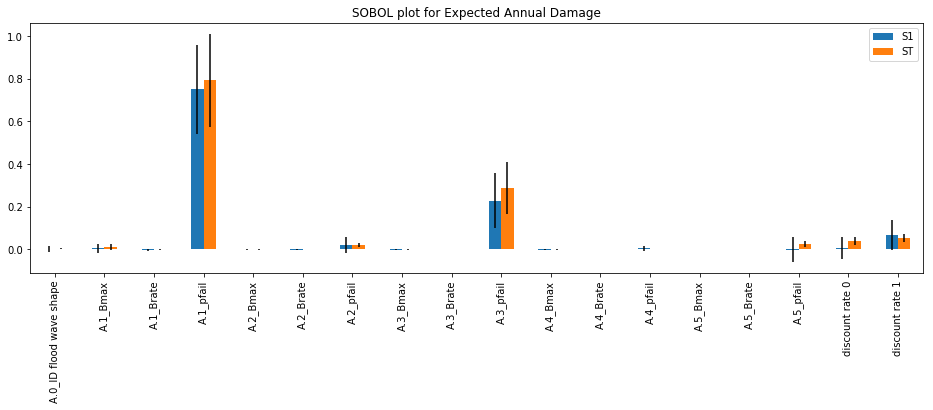

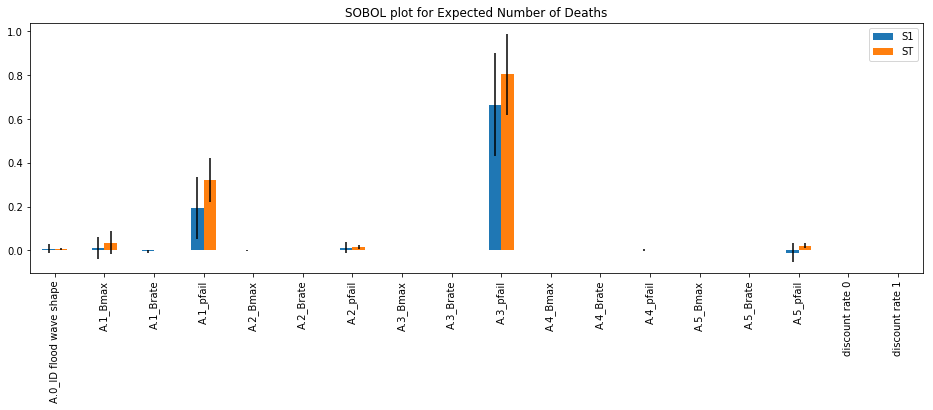

In [16]:
outcomes = ['Expected Annual Damage','Expected Number of Deaths']
for objective in outcomes:
    y = results_df[objective].values
    problem = get_SALib_problem(dike_model.uncertainties)
    Si = sobol.analyze(problem,y,calc_second_order=True, 
                       print_to_console=False)
    scores_filtered = {k:Si[k] for k in ['ST','ST_conf','S1','S1_conf']}
    Si_df = pd.DataFrame(scores_filtered, index=problem['names'])

    #sns.set_style('white')
    fig, ax = plt.subplots(1)

    indices = Si_df[['S1','ST']]
    err = Si_df[['S1_conf','ST_conf']]

    indices.plot.bar(yerr=err.values.T,ax=ax)
    fig.set_size_inches(16,6)
    fig.subplots_adjust(bottom=0.3)
    ax.set_title('SOBOL plot for ' + objective)
    plt.show()
    